In [8]:
%pip install opencv-python numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
from pathlib import Path

import cv2
import numpy as np

INPUT_DIR = Path("images")       
OUTPUT_DIR = Path("images_processed")   
IMG_SIZE = (224, 224)                

IMAGE_EXTS = {".png"}

# CLAHE – poprawa lokalnego kontrastu
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def base_preprocess(img_bgr: np.ndarray) -> np.ndarray:
    # ujednolicenie rozmiaru
    img = cv2.resize(img_bgr, IMG_SIZE)

    # odszumianie
    img = cv2.bilateralFilter(img, d=7, sigmaColor=75, sigmaSpace=75)

    # CLAHE w przestrzeni LAB
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge((l_eq, a, b))
    img = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    # wyostrzenie
    sharpen_kernel = np.array(
        [[0, -1, 0],
         [-1, 5, -1],
         [0, -1, 0]], dtype=np.float32
    )
    img = cv2.filter2D(img, -1, sharpen_kernel)

    # konwersja do skali szarości
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    return img

def list_images(input_dir: Path):
    paths = []
    for root, _, files in os.walk(input_dir):
        for f in files:
            ext = Path(f).suffix.lower()
            if ext in IMAGE_EXTS:
                paths.append(Path(root) / f)
    return paths

def main():
    image_paths = list_images(INPUT_DIR)
    if not image_paths:
        print(f"Brak obrazów w: {INPUT_DIR.resolve()}")
        return

    print(f"Znaleziono {len(image_paths)} obrazów.")

    for img_path in image_paths:
        rel_path = img_path.relative_to(INPUT_DIR)
        out_path = OUTPUT_DIR / rel_path

        out_path.parent.mkdir(parents=True, exist_ok=True)

        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            print(f"[WARN] Nie można wczytać: {img_path}")
            continue

        processed = base_preprocess(img_bgr)

        out_path = out_path.with_suffix(".png")
        cv2.imwrite(str(out_path), processed, [cv2.IMWRITE_JPEG_QUALITY, 95])

    print(f"Gotowe. Obróbka zapisana w: {OUTPUT_DIR.resolve()}")


if __name__ == "__main__":
    main()


Znaleziono 5 obrazów.


NameError: name 'clahe' is not defined

In [20]:
import os
from pathlib import Path
import cv2
import numpy as np

INPUT_DIR = Path("images")       
OUTPUT_DIR = Path("images_processed")   
IMG_SIZE = (640, 480)  

IMAGE_EXTS = {".png", ".jpg", ".jpeg"}

def process_image_edges(img_bgr: np.ndarray):
    #  resize do spójnego rozmiaru IMG_SIZE
    img = cv2.resize(img_bgr, IMG_SIZE)
    # img = img_bgr
    h, w = img.shape[:2] # wymiary po resize
    
    # konwersja na szarość
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # CLAHE kontrast
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
    # gray = clahe.apply(gray)

    # korrekcja gamma
    
    
    # rozmycie (gaussian blur)
    # blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    # Bilateral Filter ostre krawedzi 
    # blurred = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # dynamiczne progi Canny
    # mediana jasności obrazu
    v = np.median(blurred)
    sigma = 0.33
    # wyliczenie dolnego i górnego progu
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    
    # detekcja krawędzi z dynamicznymi progami
    edges = cv2.Canny(blurred, lower, upper)
    
    # Region of Interest (ROI)
    # zerujemy górne 20% obrazu ucinamy ze zdjecia perspektywę 
    roi_limit = int(h * 0.20) 
    edges[0:roi_limit, :] = 0 
    
    # operacje morfologiczne
    # dylatacja (pogrubienie) - połączenie przerywanych krawędzi
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    thick_edges = cv2.dilate(edges, kernel_dilate, iterations=2)
    
    # zamknięcie - wypełnienie dziur wewnątrz krawędzi
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed_mask = cv2.morphologyEx(thick_edges, cv2.MORPH_CLOSE, kernel_close)
    
    return closed_mask, img

def detect_and_draw(binary_mask, original_img):
    output_img = original_img.copy()
    h_img, w_img = binary_mask.shape
    
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    pothole_count = 0
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        x, y, w, h = cv2.boundingRect(cnt)
        
        # ignorowanie obiektów na krawędzi zdjęcia
        if x <= 1 or y + h >= h_img - 1 or x + w >= w_img - 1:
            continue

        if area < 800: 
            continue
 
        # aspect ratio (proporcje)
        aspect_ratio = float(w)/h
        # usuwamy pionowe kreski i bardzo płaskie obiekty
        if aspect_ratio < 0.3 or aspect_ratio > 4.0:
            continue
            
        # solidity (zwartość)
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        if hull_area == 0: continue
        solidity = float(area)/hull_area
        
        # bardziej nie regularne obiekty (dziury)
        if solidity < 0.45:
            continue

        # rysowanie
        cv2.rectangle(output_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        cv2.putText(output_img, f"Dziura ({int(area)})", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        
        pothole_count += 1
        
    return output_img, pothole_count
def list_images(input_dir: Path):
    paths = []
    for root, _, files in os.walk(input_dir):
        for f in files:
            ext = Path(f).suffix.lower()
            if ext in IMAGE_EXTS:
                paths.append(Path(root) / f)
    return paths

def main():
    image_paths = list_images(INPUT_DIR)
    if not image_paths:
        print(f"Brak obrazów w: {INPUT_DIR.resolve()}")
        return

    print(f"Znaleziono {len(image_paths)} obrazów.")

    for img_path in image_paths:
        rel_path = img_path.relative_to(INPUT_DIR)
        out_path_base = OUTPUT_DIR / rel_path.stem

        OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            continue

        # preprocessing (Edges)
        mask, resized_original = process_image_edges(img_bgr)
        
        # detekcja
        final_result, count = detect_and_draw(mask, resized_original)

        cv2.imwrite(f"{out_path_base}_edges.png", mask)
        cv2.imwrite(f"{out_path_base}_result.png", final_result)
        
        print(f"Przetworzono: {img_path.name} -> Wykryto: {count}")

    print(f"Gotowe. Sprawdź folder: {OUTPUT_DIR.resolve()}")

if __name__ == "__main__":
    main()

Znaleziono 7 obrazów.
Przetworzono: potholes294.png -> Wykryto: 5
Przetworzono: the_pothole_problem_1,000,000 reports every year (one every two minutes)-1.png -> Wykryto: 5
Przetworzono: potholes-road-image(3046x1524-crop).jpg -> Wykryto: 2
Przetworzono: the_pothole_problem_1,000,000 reports every year (one every two minutes).png -> Wykryto: 5
Przetworzono: potholes177.png -> Wykryto: 8
Przetworzono: Potholes-resized-for-blog.jpg -> Wykryto: 6
Przetworzono: potholes277.png -> Wykryto: 9
Gotowe. Sprawdź folder: /Users/kacperblotny/wsb-2nd-term/analiza-danych-multimedialnych/pothole-detection/images_processed


ZOBACZYC PRZYKLADY W WYKLADZIE I KOMBINOWAC

WIECEJ ZDJEC



Znaleziono 7 obrazów.
Przetworzono: potholes294.png -> Wykryto: 5


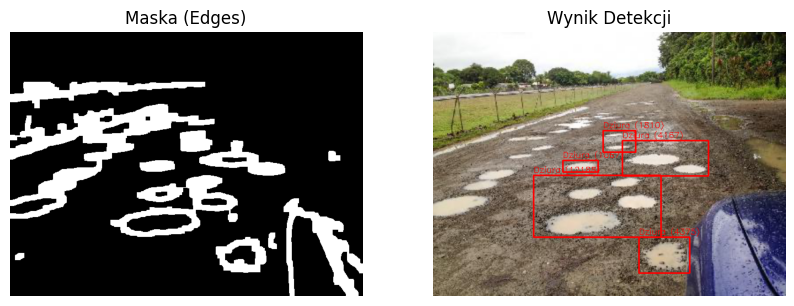

Przetworzono: the_pothole_problem_1,000,000 reports every year (one every two minutes)-1.png -> Wykryto: 5


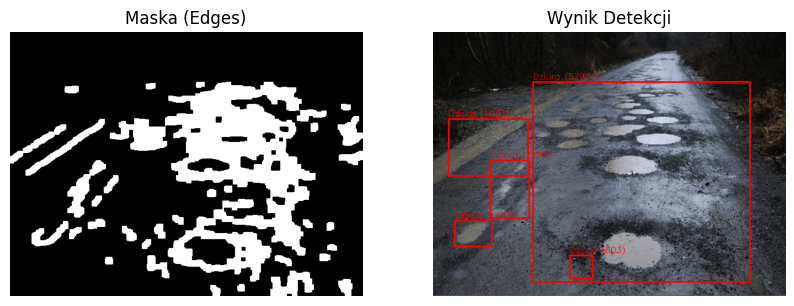

Przetworzono: potholes-road-image(3046x1524-crop).jpg -> Wykryto: 2


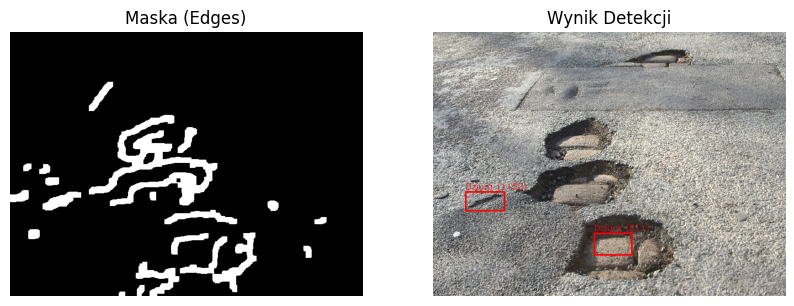

Przetworzono: the_pothole_problem_1,000,000 reports every year (one every two minutes).png -> Wykryto: 5


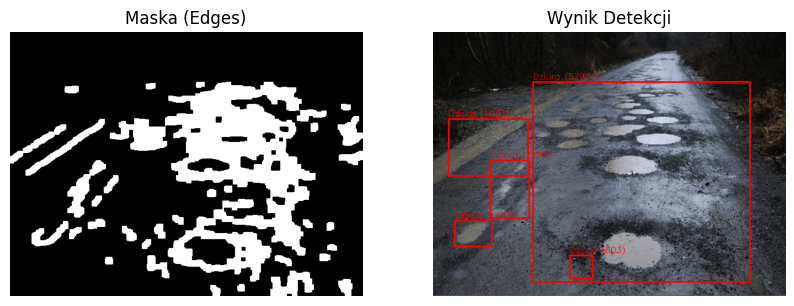

Przetworzono: potholes177.png -> Wykryto: 8


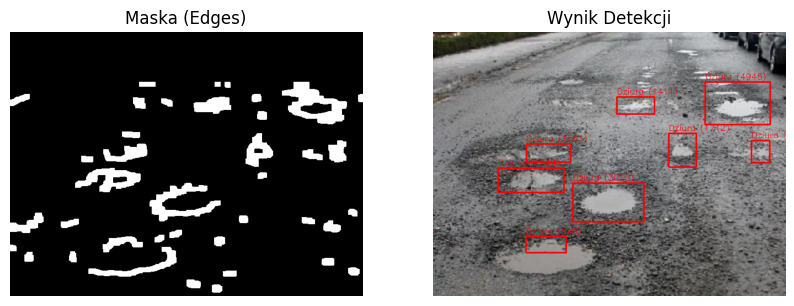

Przetworzono: Potholes-resized-for-blog.jpg -> Wykryto: 6


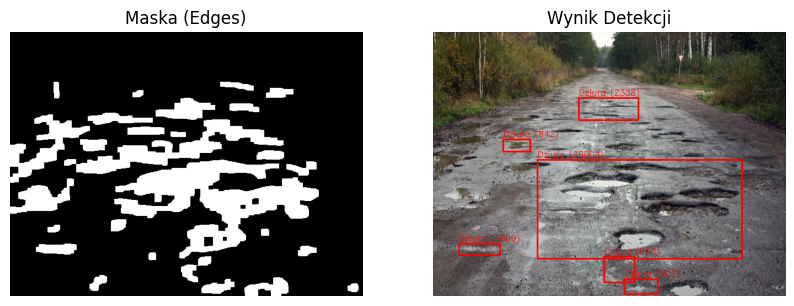

Przetworzono: potholes277.png -> Wykryto: 9


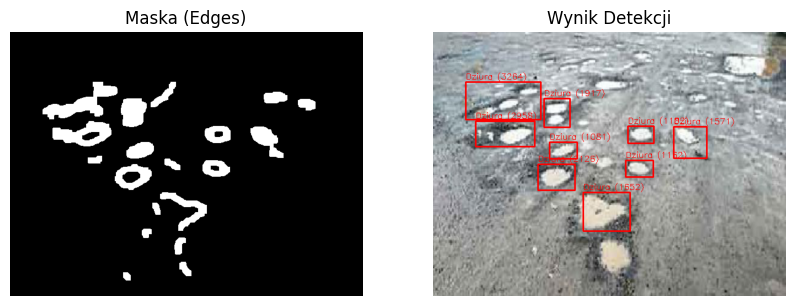

In [18]:
import matplotlib.pyplot as plt

image_paths = list_images(INPUT_DIR)

print(f"Znaleziono {len(image_paths)} obrazów.")

for img_path in image_paths:
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue

    mask, resized_original = process_image_edges(img_bgr)
    final_result, count = detect_and_draw(mask, resized_original)

    print(f"Przetworzono: {img_path.name} -> Wykryto: {count}")

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(mask, cmap='gray')
    plt.title("Maska (Edges)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
    plt.title("Wynik Detekcji")
    plt.axis('off')
    plt.show()